# Neural Spike Sorting in Calcium Imaging Data II (Sparse Parametric Deconvolution)

We are going to return to the setting we were in at the end of the last notebook: we examine one of the neural activity traces from the CaImAn-processed recording, and this time attempt to process it ourselves. Specifically, we will start this time from the *raw* fluorescence signal (i.e., before denoising), and implement a deconvolution algorithm that allows us to extract the relevant AR1 kernel parameter as well as the spike locations from this signal. We will then compare to the results we got from CaImAn.

## Setup

We load the processed data back into memory, like last time. Please check the previous notebook for a review of the data parameters we looked at previously.

In [66]:
## Download CaImAn
#!rm -rf CaImAn
!git clone https://github.com/hwagyesa/CaImAn.git
  
## Install packages we need
## Hardcoded from environment.yml (based on what's missing)
!pip install ipyparallel
!pip install peakutils
!pip install pims
!pip install tifffile

!pip install scikit-learn=='0.23.2'
!pip install h5py=='2.9.0'
!pip install Bokeh=='1.4.0'

## The data file is located at CaImAn/proc_data/cnmf_export.hdf5.

## Install Caiman
import os
os.chdir('CaImAn')
!pip install -e .

## Take care of imports
## We take these from the CaImAn demo notebook mentioned in the intro
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
#    get_ipython().magic(u'matplotlib qt')
except:
    pass
  
import numpy as np
import matplotlib.pyplot as plt
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass
import bokeh.plotting as bpl

Cloning into 'CaImAn'...
remote: Enumerating objects: 18571, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 18571 (delta 1), reused 4 (delta 1), pack-reused 18564
Receiving objects: 100% (18571/18571), 506.94 MiB | 26.45 MiB/s, done.
Resolving deltas: 100% (12388/12388), done.
Checking out files: 100% (279/279), done.
Obtaining file:///content/CaImAn/CaImAn/CaImAn
  Attempting uninstall: caiman
    Found existing installation: caiman 1.0
    Can't uninstall 'caiman'. No files were found to uninstall.
  Running setup.py develop for caiman
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
## Get data in memory.
## We are loading the processed image data, and the extracted neuron locations/traces.
cnm = cm.source_extraction.cnmf.cnmf.load_CNMF('/content/CaImAn/proc_data/cnmf_export.hdf5')
Yr, dims, T = cm.load_memmap('/content/CaImAn/proc_data/memmap__d1_128_d2_128_d3_1_order_C_frames_1000_.mmap')
images = Yr.T.reshape((T,) + dims, order='F')
cn_filter, pnr = cm.summary_images.correlation_pnr(images, gSig=cnm.params.init['gSig'][0], swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
#cnm.estimates.evaluate_components(images, cnm.params)

/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


## Understanding the Noisy Data

Last time, we worked exclusively with the denoised fluorescence signal `C`. It will be more interesting to run our deconvolution algorithm on the noisy data, though. Note thus the following additional parameter in `cnm.estimates`:
- `YrA`: This is a matrix of the same size as `C` and `S`, which contains the region-of-interest-filtered residual term for each of the fluorescence signals `C`. When we visualized the accepted components last time, we were seeing this signal in blue along with the fluorescence trace in red. See below for a re-plotting of this, and a quick verification of our own.

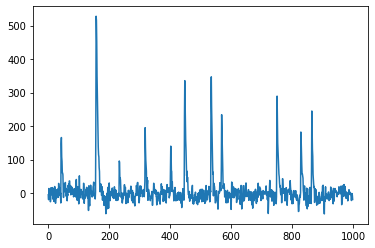

In [68]:
idx0 = cnm.estimates.idx_components[0]
plt.plot(cnm.estimates.YrA[idx0, :] + cnm.estimates.C[idx0, :])
plt.show()
bpl.output_notebook()
cnm.estimates.nb_view_components(img=cn_filter, idx=cnm.estimates.idx_components,
                                denoised_color='red', cmap='viridis')

## Setting Up Our Deconvolution Problem

Please review the optimization formulation for sparse deconvolution that we posed in the homework assignment. Corresponding to the data in that model, we will use the un-denoised signal `YrA[idx0, :] + C[idx0, :]` that we viewed above. 

We then have an appropriate notion of ground truth to compare to: we can compare the deconvolved kernel we obtain to `neuron_sn[idx0] ** range(T)`, as we generated in the previous homework, and we can compare the deconvolved spiking signal to `S[idx0, :]`. Here `T = 1000` is the length of the temporal traces we are studying; we call this dimension n in the homework handout.

In [69]:
y = cnm.estimates.YrA[idx0, :] + cnm.estimates.C[idx0, :]
y = y / np.linalg.norm(y, ord=np.inf)
gamma_star = cnm.estimates.neuron_sn[idx0]
x_star = cnm.estimates.S[idx0, :]
T = x_star.shape[0]

## Parametric Deconvolution

We give some auxiliary functions first. These will let us perform convolution and compute Lipschitz constants in a transparent way. You can use them in your solver code as black boxes, if you like: the `lip_grad_` functions especially should be used to select the step sizes $\alpha_x$ and $\alpha_\gamma$ as we indicated in the writeup.

In [70]:
## Implements circulant convolution with the fft.
def cconv(x, y):
  X = np.fft.fft(x)
  Y = np.fft.fft(y)
  return np.real(np.fft.ifft(X * Y))

## Implements circulant adjoint-convolution with the fft.
## The adjoint operation is applied to the first argument x (this is not symmetric)
## This should maybe give you a hint for computing the gradient in the writeup...
def cconv_adj(x, y):
  xc = np.flipud(x)
  x_adj = np.roll(xc, 1, axis=0)
  return cconv(x_adj, y)

# This returns the AR1 kernel for a given gamma.
def get_ar1_kernel(gamma):
  return gamma ** np.arange(T)

# This returns the AR1 kernel's first derivative for a given gamma.
# It may give you a hint for your calculation of the gradient of the objective.
# But note that it is NOT the full gradient! It is a vector, not a scalar.
def get_ar1_kernel_dot(gamma):
  return np.arange(T) * (gamma ** np.concatenate(([0], np.arange(T-1))))

# This returns the AR1 kernel's second derivative for a given gamma.
def get_ar1_kernel_dotdot(gamma):
  return np.arange(T) * np.concatenate(([0], np.arange(T-1))) * (gamma ** np.concatenate(([0, 0],np.arange(T-2))))

# This computes the objective value at our parameters. You need to pass lambda too.
def objective(gamma, x, y, lambd):
  return 0.5 * np.linalg.norm(cconv(get_ar1_kernel(gamma), x) - y, ord=2)**2 + lambd * np.linalg.norm(x, ord=1)

# This computes the step size for the x-block.
def lip_grad_x(gamma):
  a = get_ar1_kernel(gamma)
  return np.linalg.norm(np.fft.fft(a), ord=np.inf) ** 2

# This computes the step size for the gamma-block.
def lip_grad_gamma(gamma, x, y):
  a = get_ar1_kernel(gamma)
  adot = get_ar1_kernel_dot(gamma)
  adotdot = get_ar1_kernel_dotdot(gamma)
  
  c1 = np.linalg.norm(np.fft.fft(adot), ord=np.inf) ** 2
  c2 = np.linalg.norm(np.fft.fft(a), ord=np.inf)
  c3 = np.linalg.norm(y, ord=2)  
  c4 = np.linalg.norm(np.fft.fft(adotdot), ord=np.inf)

  return c1 + (c2 + c3)*c4



## Your Tasks

Complete the tasks indicated in each of the level three headers below.

### Task 1: Implementing PALM for Sparse Blind Deconvolution

Using the signal `y` that we extracted above as input, write code that implements the PALM algorithm we described in the homework handout. You will need to fill in the parts left out there: the gradient calculations, and the proximal operator calculations. Past these extra steps, the implementation should be similar to the LASSO algorithms in the other two examples from this homework; you can find a few hints about writing an iterative solver in the first task for the spectrum sensing problem.

**Hint**: Note that above, we normalized `y` by its L2 norm in order to help the optimization algorithm you create run more stably. Be sure to initialize with this scale for `y` in mind.

In [71]:
maxIter = 1e4
gamma_list = {}
x_list = {}
epsilon =0.1
lambdas_list =[0.1,0.2,0.3]

for lambda1 in lambdas_list:
  print(f"For lambda = {lambda1}.....")
  #initialization
  count = 0
  x_k = np.random.normal(0,2,size=1000)
  gamma = 0.5
  loss = []

  while(count < maxIter):
    #Updating the X
    A = cconv(x_k,get_ar1_kernel(gamma))
    gradient_x =cconv_adj(get_ar1_kernel(gamma),(A-y))
    x_kplus = x_k- np.multiply(gradient_x,(1/lip_grad_x((gamma))))
    x_k = np.sign(x_kplus)* np.maximum(np.absolute(x_kplus) -  (1/lip_grad_x(gamma))* lambda1, np.zeros(x_kplus.shape))
    #Updating the gamma
    A_bar = cconv(x_k,get_ar1_kernel(gamma))
    gradient_gamma =np.dot(cconv_adj(x_k,(A_bar-y)).T,get_ar1_kernel_dot(gamma))
    gamma_plus = gamma - np.multiply(gradient_gamma,(1/lip_grad_gamma(gamma, x_k, y)))

    if gamma_plus <= epsilon:
      gamma = epsilon
    elif gamma_plus >=(1-epsilon) :
      gamma = (1-epsilon) 
    else:
      gamma = gamma_plus

    count = count + 1

  gamma_list[lambda1] = gamma
  x_list[lambda1] = x_k
  

For lambda = 0.1.....
For lambda = 0.2.....
For lambda = 0.3.....


### Task 2: Assessing our Deconvolution Algorithm's Performance

Complete the following basic evaluation tasks:
1. Plot the recovered sparse signal `x` from your deconvolution algorithm, and in a separate plot (or on the same axes in a different color), plot the ground truth signal `x_star` that we defined above, which was output from the CaImAn processing suite. How do you compare them? 
2. Compare the AR1 parameter your algorithm extracts to the one that CaImAn estimates in `gamma_star`, which we defined above. Are they similar in value?
3. Although you have already chosen a suitable `lambda` to get the best result. Try with two different choices of `lambda` (for example, `10` times larger or smaller than your optimal `lambda`). How do you compare their results? Does it follow your intuition?  

1. Plot the recovered sparse signal `x` from your deconvolution algorithm, and in a separate plot (or on the same axes in a different color), plot the ground truth signal `x_star` that we defined above, which was output from the CaImAn processing suite. How do you compare them? 

Final Gamma for 0.1:0.8053537127026164
Final Gamma for 0.2:0.8126729940786622
Final Gamma for 0.3:0.827131133021369


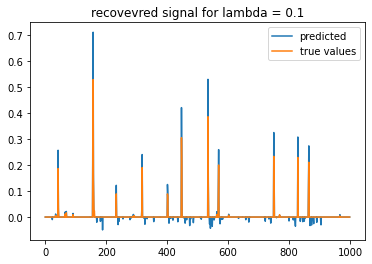

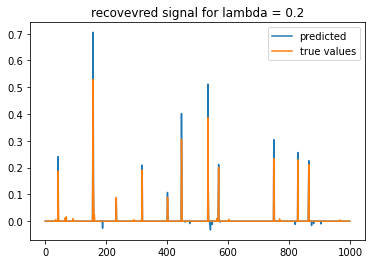

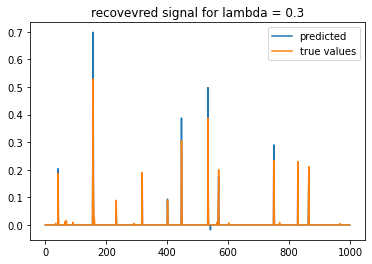

In [74]:
for lambda1 in lambdas_list:
  print(f"Final Gamma for {lambda1}:{gamma_list[lambda1]}")
  plt.figure()
  plt.plot(range(len(x_list[lambda1])), x_list[lambda1])
  plt.plot(range(len(x_star)),x_star/np.linalg.norm(x_star))
  plt.legend(['predicted','true values'])
  plt.title(f'recovevred signal for lambda = {lambda1}')


2. Compare the AR1 parameter your algorithm extracts to the one that CaImAn estimates in `gamma_star`, which we defined above. Are they similar in value?

In [75]:
for lambda1 in lambdas_list:
  print(f"Final Gamma for {lambda1}:{gamma_list[lambda1]}")
  print(f"Error of gamma with the gamma_star={gamma_list[lambda1]-gamma_star}")

Final Gamma for 0.1:0.8053537127026164
Error of gamma with the gamma_star=[0.03109421]
Final Gamma for 0.2:0.8126729940786622
Error of gamma with the gamma_star=[0.03841349]
Final Gamma for 0.3:0.827131133021369
Error of gamma with the gamma_star=[0.05287163]


3. Although you have already chosen a suitable `lambda` to get the best result. Try with two different choices of `lambda` (for example, `10` times larger or smaller than your optimal `lambda`). How do you compare their results? Does it follow your intuition?  

In [76]:
maxIter = 1e4
gamma_list = {}
x_list = {}
epsilon =0.1
lambdas_list =[0.1,0.01]

for lambda1 in lambdas_list:
  print(f"For lambda = {lambda1}.....")
  #initialization
  count = 0
  x_k = np.random.normal(0,2,size=1000)
  gamma = 0.5
  loss = []

  while(count < maxIter):
    #Updating the X
    A = cconv(x_k,get_ar1_kernel(gamma))
    gradient_x =cconv_adj(get_ar1_kernel(gamma),(A-y))
    x_kplus = x_k- np.multiply(gradient_x,(1/lip_grad_x((gamma))))
    x_k = np.sign(x_kplus)* np.maximum(np.absolute(x_kplus) -  (1/lip_grad_x(gamma))* lambda1, np.zeros(x_kplus.shape))
    #Updating the gamma
    A_bar = cconv(x_k,get_ar1_kernel(gamma))
    gradient_gamma =np.dot(cconv_adj(x_k,(A_bar-y)).T,get_ar1_kernel_dot(gamma))
    gamma_plus = gamma - np.multiply(gradient_gamma,(1/lip_grad_gamma(gamma, x_k, y)))

    if gamma_plus <= epsilon:
      gamma = epsilon
    elif gamma_plus >=(1-epsilon) :
      gamma = (1-epsilon) 
    else:
      gamma = gamma_plus

    count = count + 1

  gamma_list[lambda1] = gamma
  x_list[lambda1] = x_k

For lambda = 0.1.....
For lambda = 0.01.....


Final Gamma for 0.1:0.8053537127026164
Final Gamma for 0.01:0.7892283363606233


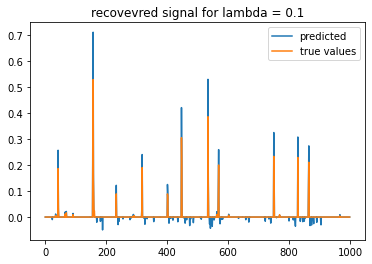

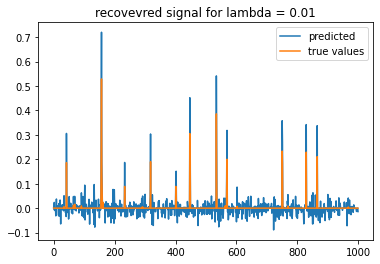

In [77]:
for lambda1 in lambdas_list:
  print(f"Final Gamma for {lambda1}:{gamma_list[lambda1]}")
  plt.figure()
  plt.plot(range(len(x_list[lambda1])), x_list[lambda1])
  plt.plot(range(len(x_star)),x_star/np.linalg.norm(x_star))
  plt.legend(['predicted','true values'])
  plt.title(f'recovevred signal for lambda = {lambda1}')

We see that for lower values of lambda there will be a lot of smaller values that act as noise and we are not able to pick the sparse spike signal.As lambda increases we see that the these are forced to zero and our prediction becomes more sparse. This makes sense because larger the lambda value, more importance is given to the 1st norm of X which to minimize drives its elements to 0. Hence, we are able to achieve and retrive the required sparse signal.
